In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [44]:
class backtesting_crossover:
    
    def __init__(self, ticker, start_date, end_date, ma_short, ma_long):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma_short = ma_short
        self.ma_long = ma_long
        self.fetchdata()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
        self.analysis()
        
    def fetchdata(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)
        
    def indicators(self):
        self.df['ma_short'] = self.df['Adj Close'].rolling(self.ma_short).mean()
        self.df['ma_long'] = self.df['Adj Close'].rolling(self.ma_long).mean()
        self.df['ma_short_prev_day'] = self.df['ma_short'].shift(1)
        self.df['ma_long_prev_day'] = self.df['ma_long'].shift(1)
        self.df.dropna(inplace=True)
    
    def signals(self):
        self.df['signal'] = np.where((self.df['ma_short'] > self.df['ma_long']) 
                            & (self.df['ma_short_prev_day'] < self.df['ma_long_prev_day']),1,0)
        self.df['signal'] = np.where((self.df['ma_short'] < self.df['ma_long']) 
                            & (self.df['ma_short_prev_day'] > self.df['ma_long_prev_day']),-1,self.df['signal'])
    
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace = 0, method = 'ffill')
#       print(self.df[60:100])
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns']*self.df['position'].shift(1)
        print('Total return: ', self.df['strategy_returns'].sum())
        return self.df['strategy_returns'].sum()

    def analysis(self):
        self.df[['ma_short','ma_long','position']].plot(figsize=(15,6),grid = True)
        plt.show()
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15,6),grid = True)
        plt.show()
        pf.create_simple_tear_sheet(self.df['strategy_returns'])

In [22]:
end1 = dt.datetime(2021,10,31).date()
start1 = end1 - pd.Timedelta(days=3*252)

In [23]:
start1

datetime.date(2019, 10, 6)

In [24]:
backtesting_crossover('AAPL',start1,end1,10,20)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-01-31  80.232498  80.669998  77.072502  77.377502  76.244957  199588400   
2020-02-03  76.074997  78.372498  75.555000  77.165001  76.035568  173788400   
2020-02-04  78.827499  79.910004  78.407501  79.712502  78.545776  136616400   
2020-02-05  80.879997  81.190002  79.737503  80.362503  79.186272  118826800   
2020-02-06  80.642502  81.305000  80.065002  81.302498  80.112495  105425600   
2020-02-07  80.592499  80.849998  79.500000  80.007500  79.023567  117684000   
2020-02-10  78.544998  80.387497  78.462502  80.387497  79.398880  109348800   
2020-02-11  80.900002  80.974998  79.677498  79.902496  78.919846   94323200   
2020-02-12  80.367500  81.805000  80.367500  81.800003  80.794022  113730400   
2020-02-13  81.047501  81.555000  80.837502  81.217

In [29]:
fast_ma_list = [5,10,15,20]
slow_ma_list = [25,50,100]

fast_ma = []
slow_ma = []
net_returns = []

for i in fast_ma_list:
    for j in slow_ma_list:
        print('For',i,j)
        a = backtesting_crossover('AAPL', start1, end1, i, j)
        fast_ma.append(i)
        slow_ma.append(j)
        net_returns.append(a.returns())

For 5 25
[*********************100%***********************]  1 of 1 completed
Total return:  0.7970909846803547
Total return:  0.7970909846803547
For 5 50
[*********************100%***********************]  1 of 1 completed
Total return:  0.22548275799238157
Total return:  0.22548275799238157
For 5 100
[*********************100%***********************]  1 of 1 completed
Total return:  0.467317301181575
Total return:  0.467317301181575
For 10 25
[*********************100%***********************]  1 of 1 completed
Total return:  0.5663468952131981
Total return:  0.5663468952131981
For 10 50
[*********************100%***********************]  1 of 1 completed
Total return:  0.23738469343371246
Total return:  0.23738469343371246
For 10 100
[*********************100%***********************]  1 of 1 completed
Total return:  0.14237396464073154
Total return:  0.14237396464073154
For 15 25
[*********************100%***********************]  1 of 1 completed
Total return:  0.24361695637555247
T

In [30]:
results = pd.DataFrame({'fast ma': fast_ma, 'slow ma': slow_ma, 'net returns': net_returns})
results

,fast ma,slow ma,net returns
0,5,25,0.797091
1,5,50,0.225483
2,5,100,0.467317
3,10,25,0.566347
4,10,50,0.237385
5,10,100,0.142374
6,15,25,0.243617
7,15,50,0.113068
8,15,100,0.145421
9,20,25,0.316402


In [32]:
results.sort_values(by = 'net returns', ascending = False)

,fast ma,slow ma,net returns
0,5,25,0.797091
3,10,25,0.566347
2,5,100,0.467317
9,20,25,0.316402
6,15,25,0.243617
4,10,50,0.237385
1,5,50,0.225483
10,20,50,0.172227
8,15,100,0.145421
5,10,100,0.142374


In [37]:
stock_list = ['PFE', 'F', 'LCID', 'NVDA', 'PTON', 'AMD', 'MRNA', 'UBER', 'BAC', 'INTC', 'NIO', 'AAPL']
stock_name = []
net_returns = []

In [38]:
for stock in stock_list:
    print('Backtesting result for', stock)
    a = backtesting_crossover(stock, start1, end1, 5, 25)
    stock_name.append(stock)
    net_returns.append(a.returns())

Backtesting result for PFE
[*********************100%***********************]  1 of 1 completed
Total return:  0.49010888138576847
Total return:  0.49010888138576847
Backtesting result for F
[*********************100%***********************]  1 of 1 completed
Total return:  0.7912078443872355
Total return:  0.7912078443872355
Backtesting result for LCID
[*********************100%***********************]  1 of 1 completed
Total return:  1.66860313684292
Total return:  1.66860313684292
Backtesting result for NVDA
[*********************100%***********************]  1 of 1 completed
Total return:  -0.1884478859616186
Total return:  -0.1884478859616186
Backtesting result for PTON
[*********************100%***********************]  1 of 1 completed
Total return:  1.480369329997603
Total return:  1.480369329997603
Backtesting result for AMD
[*********************100%***********************]  1 of 1 completed
Total return:  -0.15596749011429242
Total return:  -0.15596749011429242
Backtesting r

In [39]:
results1 = pd.DataFrame({'Stock': stock_name, 'Net Returns': net_returns})
results1

,Stock,Net Returns
0,PFE,0.490109
1,F,0.791208
2,LCID,1.668603
3,NVDA,-0.188448
4,PTON,1.480369
5,AMD,-0.155967
6,MRNA,0.348440
7,UBER,-1.425493
8,BAC,-0.071781
9,INTC,-0.255515


In [41]:
results1.sort_values(by = 'Net Returns', ascending = False)

,Stock,Net Returns
10,NIO,2.662826
2,LCID,1.668603
4,PTON,1.480369
11,AAPL,0.797091
1,F,0.791208
0,PFE,0.490109
6,MRNA,0.348440
8,BAC,-0.071781
5,AMD,-0.155967
3,NVDA,-0.188448


[*********************100%***********************]  1 of 1 completed
Total return:  2.6628262997783927


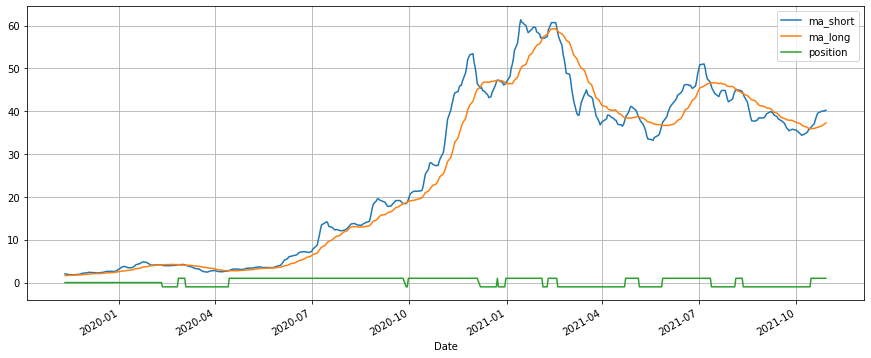

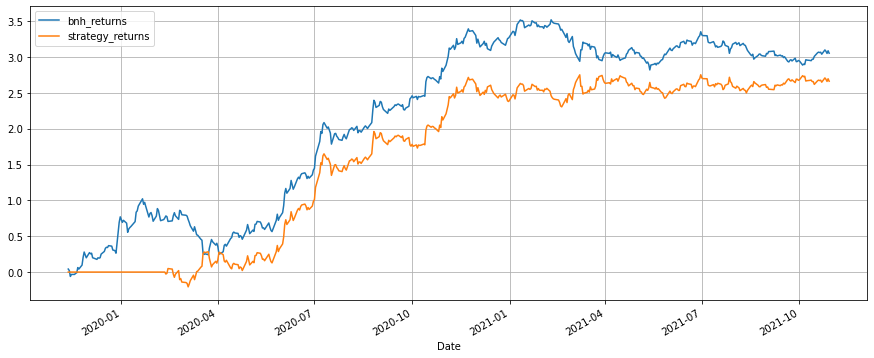

Start date,2019-11-11
End date,2021-10-29
Total months,23
,Backtest
Annual return,184.0%
Cumulative returns,683.7%
Annual volatility,79.1%
Sharpe ratio,1.71
Calmar ratio,4.93
Stability,0.80
Max drawdown,-37.3%


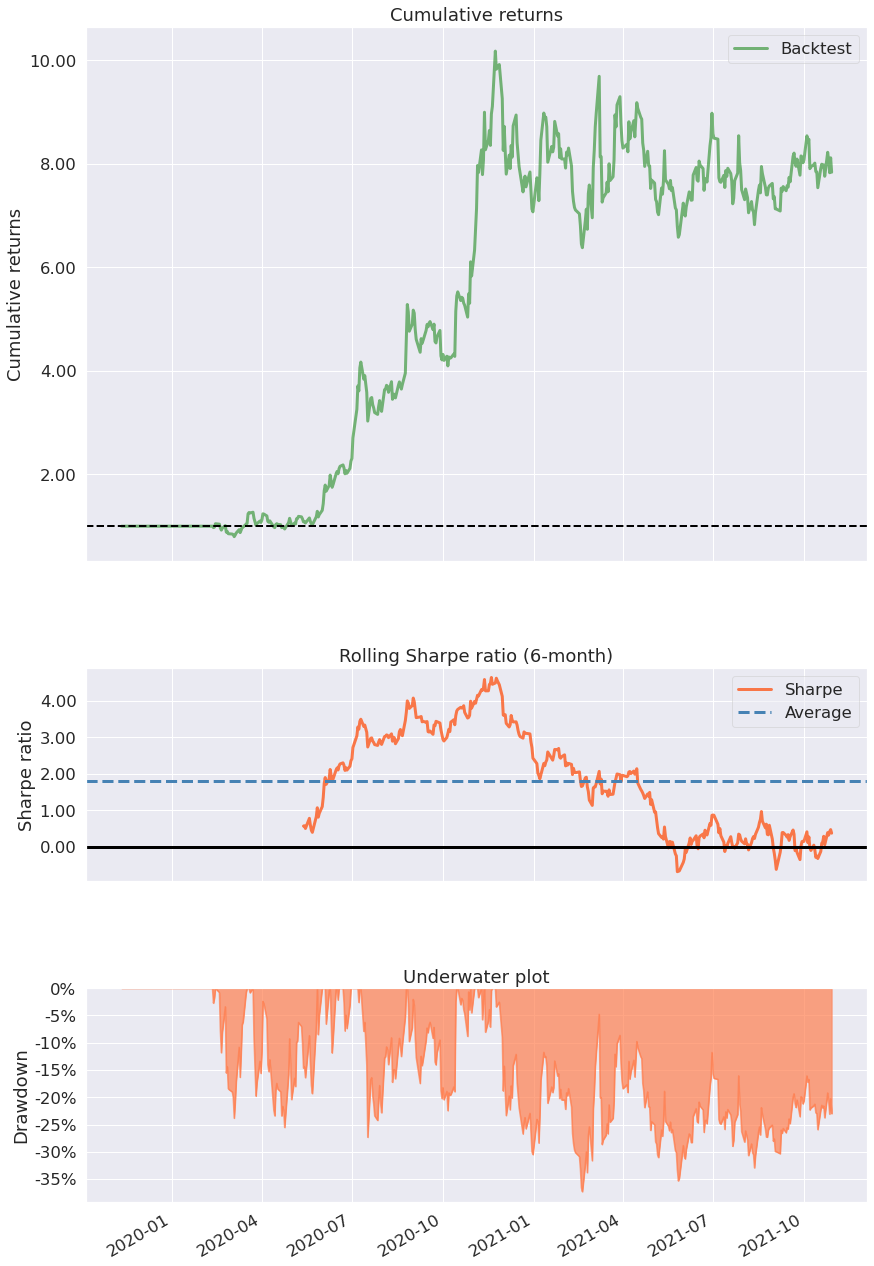

In [45]:
backtesting_crossover('NIO',start1,end1,5,25)